In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, plot_confusion_matrix

from sklearn.pipeline import make_pipeline , Pipeline
import re

#### Load Dataframe

In [2]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv',encoding='latin1')

#### Rename columns for simplicity

In [3]:
df.rename(columns = {'emotion_in_tweet_is_directed_at': 'Product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion', 'tweet_text': 'Tweet'}, inplace= True)

In [4]:
df.drop(9092, inplace=True)
df.reset_index(drop=True, inplace=True)

#### LowerCase tweets for ease of use

In [5]:
df['Text'] = df['Tweet'].str.lower()
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '')
df['Text'] = df['Text'].str.split(' ')

<ipython-input-5-fe1692285ef5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace(r'[^\w\s]', '')


In [6]:
df.dropna(subset=['Text'], inplace=True)

In [7]:
emotion_dict = {'No emotion toward brand or product' : 'Neutral emotion', "I can't tell": 'Neutral emotion', 'Positive emotion': 'Positive emotion',
               'Negative emotion': 'Negative emotion'}
df['Emotion'] = df['Emotion'].map(emotion_dict)

In [8]:
from nltk.tokenize import TweetTokenizer
ttokenize = TweetTokenizer(preserve_case=False, reduce_len=False)

In [9]:
df['clean_tweet'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet)
                           for tweet in df['Tweet']]

In [10]:
df['clean_tweet'] = df['Tweet'].str.replace(r'[^\w\s]', '')

<ipython-input-10-66a8f6713723>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_tweet'] = df['Tweet'].str.replace(r'[^\w\s]', '')


In [11]:
def clean_tweet(tweet):
    token = ttokenize.tokenize(tweet)
    tokens = [word.lower() for word in token]
    no_sw = [word for word in tokens if word not in sw]
    lemmad = [lemma.lemmatize(word) for word in no_sw]
    return lemmad
    

In [12]:
sw = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [13]:
df['clean_tweet'] = df['clean_tweet'].apply(clean_tweet)

### Add Target values


In [14]:
target_dict = {'Negative emotion': 0, 'Neutral emotion': 1, 'Positive emotion': 2}
df['target'] = df['Emotion'].map(target_dict)

#### Seperate Dataframes by company

#### Seperate Dataframes by tweet sentiment

In [15]:
df_pos = df.loc[df.target == 2]
df_neg = df.loc[df.target == 0]
df_neutral = df.loc[df.target == 1]

#### Lists/Dictionary of words used in pos/neg/neutral tweets

In [16]:
pos_words = []
neg_words = []
neutral_words = []

for list_ in df_pos['Text']:
    for word in list_:
        pos_words.append(word)

        
for list_ in df_neg['Text']:
    for word in list_:
        neg_words.append(word)
        
        
for list_ in df_neutral['Text']:
    for word in list_:
        neutral_words.append(word)
    

In [17]:
from collections import Counter
sw = stopwords.words('english')

In [18]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [19]:
pos_words = [lemma.lemmatize(word) for word in pos_words if word not in sw]
neg_words = [lemma.lemmatize(word) for word in neg_words if word not in sw]
neutral_words =  [lemma.lemmatize(word) for word in neutral_words if word not in sw]



In [20]:
pos_dict = Counter(pos_words)
neg_dict = Counter(neg_words)
neutral_dict = Counter(neutral_words)

In [21]:
pos_dict = dict(sorted(pos_dict.items(), key=lambda item: item[1], reverse=True))
neg_dict = dict(sorted(neg_dict.items(), key=lambda item: item[1], reverse=True))
neutral_dict = dict(sorted(neutral_dict.items(), key=lambda item: item[1], reverse=True))

In [22]:
pos_dict.pop('')
neg_dict.pop('')
neutral_dict.pop('')

2098

In [23]:
dict(list(pos_dict.items())[0:20])

{'sxsw': 3068,
 'mention': 2113,
 'link': 1206,
 'ipad': 982,
 'rt': 922,
 'apple': 875,
 'google': 690,
 'store': 549,
 'iphone': 520,
 '2': 497,
 'app': 391,
 'new': 359,
 'austin': 292,
 'popup': 218,
 'ipad2': 202,
 'android': 198,
 'amp': 181,
 'get': 181,
 'launch': 174,
 'one': 148}

In [24]:
dict(list(neg_dict.items())[0:20])

{'sxsw': 578,
 'mention': 301,
 'ipad': 181,
 'iphone': 155,
 'google': 141,
 'rt': 137,
 'apple': 106,
 'link': 101,
 '2': 65,
 'app': 60,
 'store': 45,
 'new': 43,
 'like': 42,
 'circle': 36,
 'need': 35,
 'social': 30,
 'apps': 30,
 'people': 29,
 'design': 28,
 'get': 25}

#### Adding common words used in both positive and negative tweets to stopwords list

In [25]:
common_words = ['sxsw', 'mention', 'link', 'ipad', 'iphone', 'google', 'apple', '2', 'android', 'rt']


In [26]:
sw.extend(common_words)

## Visualizations

#### Models with tokenized tweets

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split , cross_validate , GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [30]:
df_test = df.drop(['Product', 'Emotion'], axis=1)

In [31]:
X = df_test['clean_tweet'].str.join(' ')
y = df_test.target


In [32]:
raw_pos = []
raw_neg = []
raw_neu = []

pos_tweets = df_test.loc[df.target==2]
pos_tweets

neg_tweets = df_test.loc[df.target==0]

neutral_tweets = df_test.loc[df.target==1]

for listx in pos_tweets.clean_tweet:
    for x in listx:
        raw_pos.append(x)
    
for listx in neg_tweets.clean_tweet:
    for x in listx:
        raw_neg.append(x)
        
for listx in neutral_tweets.clean_tweet:
    for x in listx:
        raw_neu.append(x)

In [33]:
raw_pos

['jessedee',
 'know',
 'fludapp',
 'awesome',
 'ipadiphone',
 'app',
 'youll',
 'likely',
 'appreciate',
 'design',
 'also',
 'theyre',
 'giving',
 'free',
 't',
 'sxsw',
 'swonderlin',
 'wait',
 'ipad',
 '2',
 'also',
 'sale',
 'sxsw',
 'sxtxstate',
 'great',
 'stuff',
 'fri',
 'sxsw',
 'marissa',
 'mayer',
 'google',
 'tim',
 'oreilly',
 'tech',
 'booksconferences',
 'amp',
 'matt',
 'mullenweg',
 'wordpress',
 'sxsw',
 'starting',
 'ctia',
 'around',
 'corner',
 'googleio',
 'hop',
 'skip',
 'jump',
 'good',
 'time',
 'android',
 'fan',
 'beautifully',
 'smart',
 'simple',
 'idea',
 'rt',
 'madebymany',
 'thenextweb',
 'wrote',
 'hollergram',
 'ipad',
 'app',
 'sxsw',
 'httpbitlyieavob',
 'counting',
 'day',
 'sxsw',
 'plus',
 'strong',
 'canadian',
 'dollar',
 'mean',
 'stock',
 'apple',
 'gear',
 'excited',
 'meet',
 'samsungmobileus',
 'sxsw',
 'show',
 'sprint',
 'galaxy',
 'still',
 'running',
 'android',
 '21',
 'fail',
 'find',
 'amp',
 'start',
 'impromptu',
 'party',
 'sxsw

In [34]:
raw_pos = ' '.join(raw_pos)
raw_neg = ' '.join(raw_neg)
raw_neu = ' '.join(raw_neu)

In [35]:
word_list = [raw_pos, raw_neg, raw_neu]

In [38]:
df_raw = pd.DataFrame(word_list, index = ['positive', 'negative', 'neutral'], columns = ['raw_text'])
df_raw.head()

,raw_text
positive,jessedee know fludapp awesome ipadiphone app y...
negative,wesley 83 3g iphone 3 hr tweeting rise_austin ...
neutral,teachntech 00 new ipad apps speechtherapy comm...


In [39]:
tfidf_raw = TfidfVectorizer(stop_words = sw, max_features=500)
X_raw = tfidf_raw.fit_transform(df_raw.raw_text)
df_topwords = pd.DataFrame(X_raw.toarray(), columns = tfidf_raw.get_feature_names(), index=df_raw.index)

In [40]:
tfidf_raw

TfidfVectorizer(max_features=500,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [41]:
top_poswords = dict(df_topwords.loc[['positive']].max().sort_values(ascending=False)[:150])

In [42]:
top_poswords

{'store': 0.4460859665691307,
 'app': 0.31932929847298425,
 'new': 0.29170284516997796,
 'austin': 0.2372624813081715,
 'popup': 0.17713431823692258,
 'get': 0.1470702367012981,
 'amp': 0.1470702367012981,
 'launch': 0.14138243749185564,
 'one': 0.12025632614249789,
 'party': 0.11456852693305543,
 'line': 0.11456852693305543,
 'time': 0.10969327046781902,
 'great': 0.10969327046781902,
 'via': 0.10644309949099476,
 'social': 0.10075530028155229,
 'free': 0.09913021479314016,
 'cool': 0.09506750107210982,
 'day': 0.09506750107210982,
 'map': 0.09425495832790375,
 'win': 0.09344241558369769,
 'like': 0.09262987283949162,
 'im': 0.09100478735107949,
 'today': 0.09100478735107949,
 'circle': 0.09019224460687342,
 'go': 0.08369190265322489,
 'come': 0.08206681716481275,
 'mobile': 0.08044173167640062,
 'sxswi': 0.07719156069957635,
 'love': 0.07556647521116422,
 'network': 0.07394138972275208,
 'awesome': 0.07312884697854602,
 'temporary': 0.07231630423433995,
 'opening': 0.0715037614901338

In [43]:
top_negwords = dict(df_topwords.loc[['negative']].max().sort_values(ascending=False)[:200])

In [44]:
top_negwords

{'app': 0.3064738766191898,
 'store': 0.22985540746439231,
 'new': 0.219639611577086,
 'like': 0.21453171363343285,
 'circle': 0.18388432597151386,
 'need': 0.1787764280278607,
 'social': 0.1532369383095949,
 'apps': 0.1532369383095949,
 'people': 0.1481290403659417,
 'design': 0.14302114242228856,
 'get': 0.12769744859132906,
 'austin': 0.1225895506476759,
 'time': 0.11748165270402275,
 'one': 0.11748165270402275,
 'think': 0.11748165270402275,
 'dont': 0.10726585681671642,
 'look': 0.10726585681671642,
 'launch': 0.10726585681671642,
 'say': 0.10215795887306325,
 'line': 0.10215795887306325,
 'day': 0.10215795887306325,
 'would': 0.0970500609294101,
 'news': 0.09194216298575693,
 'today': 0.09194216298575693,
 'phone': 0.08683426504210377,
 'long': 0.08683426504210377,
 'fail': 0.08683426504210377,
 'go': 0.08683426504210377,
 'product': 0.0817263670984506,
 'battery': 0.0817263670984506,
 'user': 0.0817263670984506,
 'year': 0.0817263670984506,
 'company': 0.07661846915479745,
 'goo

In [45]:
top_negwords.keys()

dict_keys(['app', 'store', 'new', 'like', 'circle', 'need', 'social', 'apps', 'people', 'design', 'get', 'austin', 'time', 'one', 'think', 'dont', 'look', 'launch', 'say', 'line', 'day', 'would', 'news', 'today', 'phone', 'long', 'fail', 'go', 'product', 'battery', 'user', 'year', 'company', 'good', 'much', 'im', 'network', 'popup', 'thing', 'headache', 'ive', 'talk', 'see', 'major', 'cant', 'amp', 'way', 'money', 'take', 'via', 'many', 'called', 'doesnt', 'room', 'really', 'going', 'fast', 'back', 'tapworthy', 'wait', 'already', 'yet', 'twitter', 'know', 'first', 'japan', 'guy', 'sxswi', 'instead', 'quoti', 'come', 'coming', 'quotapple', 'better', 'session', 'still', 'mayer', 'every', 'made', 'blackberry', 'bing', 'best', 'gave', 'nothing', 'want', 'heard', 'content', 'ever', 'everyone', 'even', 'didnt', 'use', 'another', 'map', 'diller', 'getting', 'weekend', 'may', 'last', 'hand', 'ipads', 'great', 'morning', 'panel', 'give', 'life', 'make', 'lost', 'ûïmention', 'digital', 'wont', '

In [46]:
pos_keys = []
pos_vals = []

In [49]:
for word, item in top_poswords.items():
    if word not in top_negwords.keys():
        pos_keys.append(word)
        pos_vals.append(item)

In [50]:
pos_dict1 = dict(zip(pos_keys, pos_vals))
del pos_dict1['conferencesquot']
# del pos_dict1['ûïmention']

In [51]:
pos_dict1

{'free': 0.09913021479314016,
 'cool': 0.09506750107210982,
 'win': 0.09344241558369769,
 'awesome': 0.07312884697854602,
 'opening': 0.07150376149013388,
 'downtown': 0.07150376149013388,
 'check': 0.06256579130386715,
 'fun': 0.05336113296556119,
 'video': 0.04875256465236401,
 'begin': 0.048129649341486565,
 'pop': 0.04712747916395187,
 'case': 0.04631493641974581,
 'set': 0.043064765442921545,
 'shop': 0.04225222269871547,
 'nice': 0.04062713721030334,
 'smart': 0.039814594466097274,
 'game': 0.03900205172189121,
 'music': 0.03871297881815224,
 'team': 0.03818950897768514,
 'wow': 0.03412679525665481,
 'marketing': 0.03412679525665481,
 'week': 0.03412679525665481,
 'giving': 0.03348149519407761,
 'rumor': 0.03087662427983054,
 'others': 0.030342605019632835,
 'rock': 0.029296308294817913,
 'event': 0.029296308294817913,
 'could': 0.029251538791418407,
 'show': 0.02843899604721234,
 'ill': 0.02843899604721234,
 'winning': 0.02825001157000298,
 'school': 0.02825001157000298,
 'congr

In [52]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

(-0.5, 7999.5, 4999.5, -0.5)

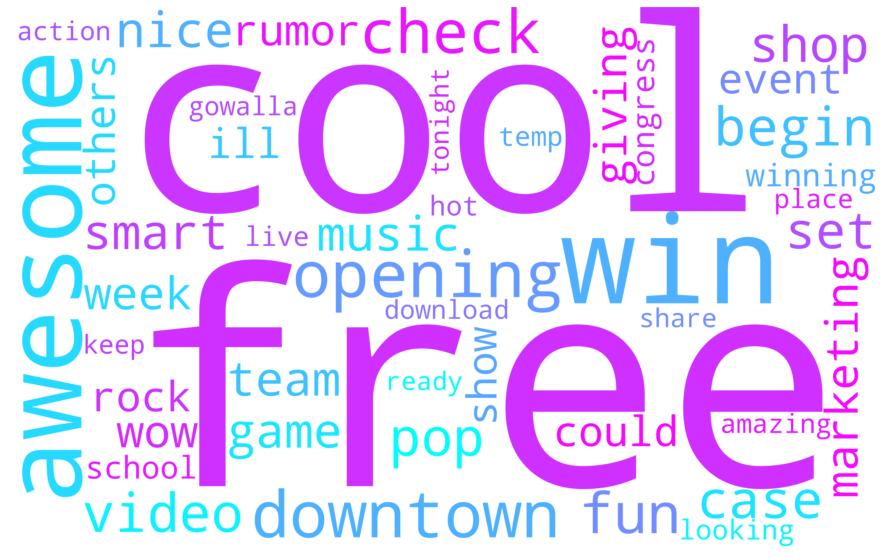

In [53]:
wc = WordCloud(background_color="white",width=8000,height=5000, max_words=50,relative_scaling=0.5,normalize_plurals=False, colormap = 'cool').generate_from_frequencies(pos_dict1)
plt.figure( figsize=(20,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [54]:
top_poswords

{'store': 0.4460859665691307,
 'app': 0.31932929847298425,
 'new': 0.29170284516997796,
 'austin': 0.2372624813081715,
 'popup': 0.17713431823692258,
 'get': 0.1470702367012981,
 'amp': 0.1470702367012981,
 'launch': 0.14138243749185564,
 'one': 0.12025632614249789,
 'party': 0.11456852693305543,
 'line': 0.11456852693305543,
 'time': 0.10969327046781902,
 'great': 0.10969327046781902,
 'via': 0.10644309949099476,
 'social': 0.10075530028155229,
 'free': 0.09913021479314016,
 'cool': 0.09506750107210982,
 'day': 0.09506750107210982,
 'map': 0.09425495832790375,
 'win': 0.09344241558369769,
 'like': 0.09262987283949162,
 'im': 0.09100478735107949,
 'today': 0.09100478735107949,
 'circle': 0.09019224460687342,
 'go': 0.08369190265322489,
 'come': 0.08206681716481275,
 'mobile': 0.08044173167640062,
 'sxswi': 0.07719156069957635,
 'love': 0.07556647521116422,
 'network': 0.07394138972275208,
 'awesome': 0.07312884697854602,
 'temporary': 0.07231630423433995,
 'opening': 0.0715037614901338

In [55]:
neg_keys = []
neg_vals = []

In [56]:
for word, item in top_negwords.items():
    if word not in top_poswords.keys():
        neg_keys.append(word)
        neg_vals.append(item)

In [57]:
neg_dict1 = dict(zip(neg_keys, neg_vals))
del neg_dict1['quoti']
del neg_dict1['ive']

(-0.5, 7999.5, 4999.5, -0.5)

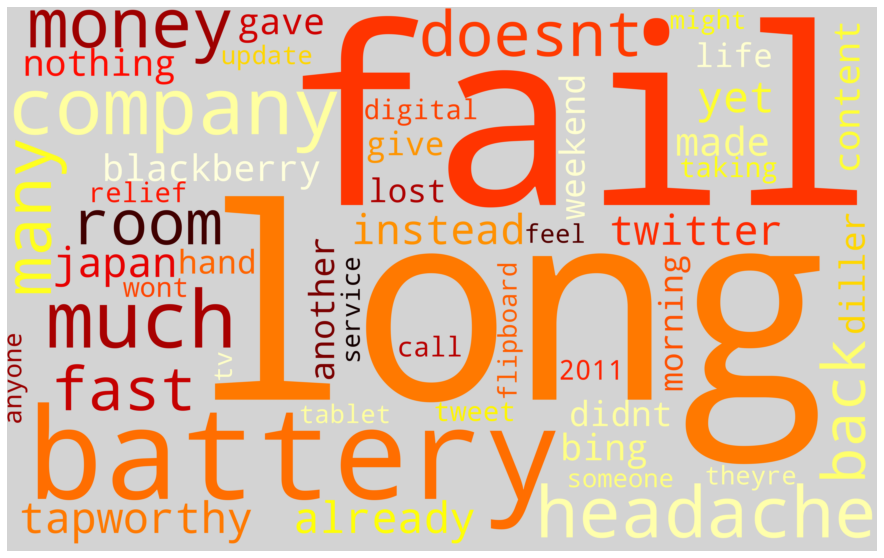

In [58]:
wc = WordCloud(background_color="lightgray",width=8000,height=5000, max_words=50,relative_scaling=0.5,normalize_plurals=False, colormap = 'hot').generate_from_frequencies(neg_dict1)
plt.figure( figsize=(20,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")